In [26]:
# Import required Libraries
import pandas as pd
import os
from pandas import json_normalize
import json
import requests
from IPython.display import JSON

### Weather Functions

In [25]:
# Weather API Fetch Function
def world_weather_fetch(query):
    
        # Set Key
        weather_key = os.environ['weather_api_key']
        
        # Set Parameters for API
        weather_url = "http://api.worldweatheronline.com/premium/v1/weather.ashx?"
        location = query
        weather_response = requests.get(weather_url,params={
                                                  'q':location,
                                                  'date':'2019-01-01',
                                                  'fx':'no',
                                                  'cc':'no',
                                                  'mca':'yes',
                                                  'format':'json',
                                                  'key':weather_key})
        
        # Call API and direct returned information
        weather_result = weather_response.json()
        df_weather = json_normalize(weather_result)
        return weather_result, df_weather

In [24]:
# Function to Call Weather API Function through loop and then collect/compile data
def compile_weather_data(string_list):
    
    # Set up initial dataframe to add column datas onto
    init_result,init_data = world_weather_fetch(string_list[0])
    init_data = json_normalize(data=init_data['data.ClimateAverages'][0][0]['month'])
    base_data = init_data[['avgRainDays','avgDryDays','avgCloud','avgSnowDays']].apply(pd.to_numeric)
    
    # Loop through list of locations and collect API data
    for i in string_list[1:]:
        result,dataframe = world_weather_fetch(i)
        weather_dataframe = json_normalize(data=dataframe['data.ClimateAverages'][0][0]['month'])
        base_data[['avgRainDays','avgDryDays','avgCloud','avgSnowDays']] = base_data + weather_dataframe[['avgRainDays','avgDryDays','avgCloud','avgSnowDays']].apply(pd.to_numeric)
    
    # Calculate Average of each column value based on each city added
    base_data = base_data/len(string_list)
    # Replace column data with adjusted values
    init_data[['avgRainDays','avgDryDays','avgCloud','avgSnowDays']] = init_data[['avgRainDays','avgDryDays','avgCloud','avgSnowDays']].replace(base_data[['avgRainDays','avgDryDays','avgCloud','avgSnowDays']])
    return init_data
        

### Compile Weather Data

In [27]:
# Import Data list for Weather API Queries
import pickle
infile = open('most_freq_delayed_flight_locations_2019','rb')
most_frequently_delayed = pickle.load(infile)
infile.close()

In [53]:
data = compile_weather_data(most_frequently_delayed)
weather_data_delayed = data[['name','avgRainDays','avgDryDays','avgCloud','avgSnowDays']]

In [54]:
# Change month names to numeric values
weather_data_delayed['name'] = pd.to_datetime(weather_data_delayed.name, format='%B').dt.month
# Change int values to floats
weather_data_delayed['name'] = pd.to_numeric(weather_data_delayed['name'], downcast='float')

<ipython-input-54-e63c9078f8ab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data_delayed['name'] = pd.to_datetime(weather_data_delayed.name, format='%B').dt.month


In [178]:
# Create specific dataframes pertaining to each weather patter and rename column to month
sunny_days = weather_data_delayed[['name','avgDryDays']].rename({'name': 'month'}, axis=1)
rainy_days = weather_data_delayed[['name','avgRainDays']].rename({'name': 'month'}, axis=1)
cloudy_days = weather_data_delayed[['name','avgCloud']].rename({'name': 'month'}, axis=1)
snow_days = weather_data_delayed[['name','avgSnowDays']].rename({'name': 'month'}, axis=1)

### Adjust Data for histogram plot

In [148]:
# import graph objects from plotly 
import plotly.graph_objs as go

# Import Data list for Weather API Queries
import pickle
infile = open('Monthly_flight_delays','rb')
monthly_flight_delays = pickle.load(infile)
infile.close()

In [179]:
# Scale Cloudy data for graphing purposes
cloudy_days = cloudy_days.astype({'avgCloud': 'float64'})
cloudy_days['avgCloud'] = cloudy_days['avgCloud'].div(10).round(0)
cloudy_days = cloudy_days.astype({'avgCloud': 'int64'})

# Adjust data types for frames
sunny_days = sunny_days.astype({'avgDryDays': 'int64'})
rainy_days = rainy_days.astype({'avgRainDays': 'int64'})
snow_days = snow_days.astype({'avgSnowDays': 'int64'})

In [264]:
# Combine weather dataframes 
weather_delay_patterns = pd.merge(monthly_flight_delays,sunny_days,on='month')
lst = [rainy_days,cloudy_days,snow_days]

for i in lst:
    weather_delay_patterns = pd.merge(weather_delay_patterns, i, on='month')

In [266]:
# Scale Count data for Graphing
weather_delay_patterns['count'] = weather_delay_patterns['count'].div(1000).round(1)

### Plot Graph

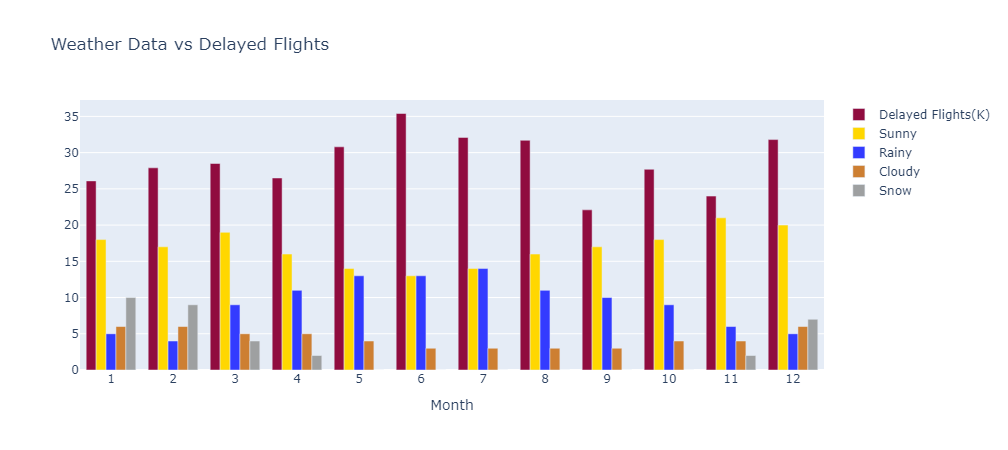

In [267]:
# Plot data to visualize Number of delayed flights per months to monthly weather patterns
trace0 = go.Bar(
                x=weather_delay_patterns['month'],  
                y=weather_delay_patterns['count'],
                name = 'Delayed Flights(K)',
                marker=dict(color='#900C3F') # set the marker color to Gold
                )

trace1 = go.Bar(
                x=weather_delay_patterns['month'],  
                y=weather_delay_patterns['avgDryDays'],
                name = 'Sunny',
                marker=dict(color='#FFD700') # set the marker color to Gold
                )

# trace2 - Rainy
trace2 = go.Bar(
                x=weather_delay_patterns['month'],
                y=weather_delay_patterns['avgRainDays'],
                name='Rainy',
                marker=dict(color='#333BFF') # set the marker color to Blue
                )

# trace3 - Cloudy
trace3 = go.Bar(
                x=weather_delay_patterns['month'],
                y=weather_delay_patterns['avgCloud'],
                name='Cloudy',
                marker=dict(color='#CD7F32') # set the marker color to Bronze
                )

# trace4 - Snow
trace4 = go.Bar(
                x=weather_delay_patterns['month'],
                y=weather_delay_patterns['avgSnowDays'],
                name='Snow',
                marker=dict(color='#9EA0A1') # set the marker color to Silver
                )

# create the data
data = [trace0,trace1, trace2, trace3, trace4]

# create the layout
layout = go.Layout(yaxis={'type': 'linear'},
                   xaxis={'type':'category',
                          'title':'Month'},
                   title='Weather Data vs Delayed Flights')

# create the figure
fig = go.Figure(data=data, layout=layout)
fig.show()

### Compare Distributions for each Weather Pattern

#### Observation == Expection
Delayed flights distribution ==> Uniformly Distributed around June/July

#### Surprisingly No Distributional Correlation
no relationship correlation

Sunny Weather ==> Bimodal Distribution (1 Peaks Between Jan-Mar & 1 Peak Sept-December)

#### Observation == Delayed Flight Distribution
Relationship correlation

Rainy Weather ==> Uniformly Distributed around June/July

#### Observation =/= Delayed Flights Distribution
no relationship correlation

Cloudy Weather ==> Bimodal Distribution (1 Peak Between January/February & 1 Peak October-December)

#### Observation == Delayed Flight Distrution Exactly for each Peak Period
Relationship correlation

Snowy Weather ==> Bimodal Distribution (1Peak between January/February/March & 1 Peak December)